# 割引 Coupon Campaign の効果最大化
## Data 理解
### Data の確認

#### 会員 Data の確認

In [1]:
import pandas as pd

cust_df = pd.read_csv('customers.csv')
cust_df.shape

(5000, 3)

すべての行を確認するのは大変な為、上部 Record を見てみる。

In [2]:
# File の上部 Record
cust_df.head()

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0


In [3]:
# Data の型
cust_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

各 Column の意味
- customer_id: 会員 ID. (※ 1 ~ 5,000 の間で Unique な整数値をとる。)
- age_cat: 齢区分
- freq_cat: 昨年度来店回数区分

年齢区分と昨年度来店回数について、分布を可視化して確認する。

<AxesSubplot:>

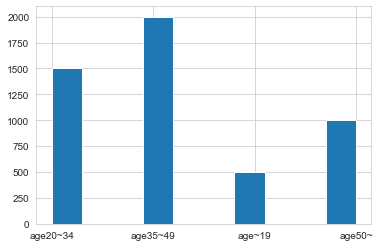

In [4]:
cust_df['age_cat'].hist()

<AxesSubplot:>

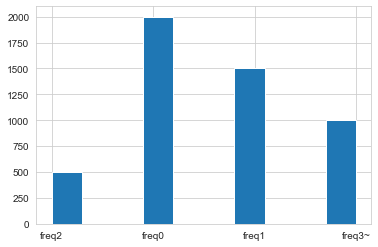

In [5]:
cust_df['freq_cat'].hist()

年齢層と来店回数の組み合わせの人数を確認してみる。

In [6]:
cust_pivot_df = pd.pivot_table(data=cust_df, values='customer_id', columns='freq_cat', index='age_cat', aggfunc='count')
cust_pivot_df = cust_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


理解を促進するために、２軸の Heatmap を描画する。

<AxesSubplot:xlabel='freq_cat', ylabel='age_cat'>

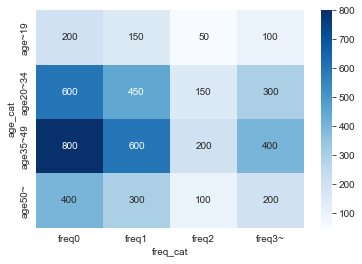

In [7]:
import seaborn as sns

sns.heatmap(cust_pivot_df, annot=True, fmt='d', cmap='Blues')
# annot= : True: Cell　上に値を出力する。
# fmt= : 文字列 Format を指定する。
# cmap= : Colormap を Design.

年齢区分と昨年度来店回数区分の組合せでは、
- 35~49歳と昨年度来店数０回が多い
- 19歳以下と昨年度来店回数２回が少ない

#### 来店率 Data の確認

In [8]:
prob_df = pd.read_csv('visit_probability.csv')
prob_df.shape

(16, 6)

16行と比較的小さい Data のため、全 Record を確認してみる。

In [9]:
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


各 Column の意味
- age_cat: 年齢区分
- freq_cat: 昨年度来店回数区分
- segment_id: 年齢区分と昨年度来店回数分の君合わせによる会員の Segment
- prob_dm1: 当該 Segment に Sale のチラシのみの DM を送付したときの来店率
- prob_dm2: 当該 Segment に Sale のチラシと 1,000円の Coupon の DM を送付したときの来店率
- prob_dm3: 当該 Segment に Sale のチラシと 2,000円の Coupon の DM を送付したときの来店率

全体の傾向を捉えるために可視化する。

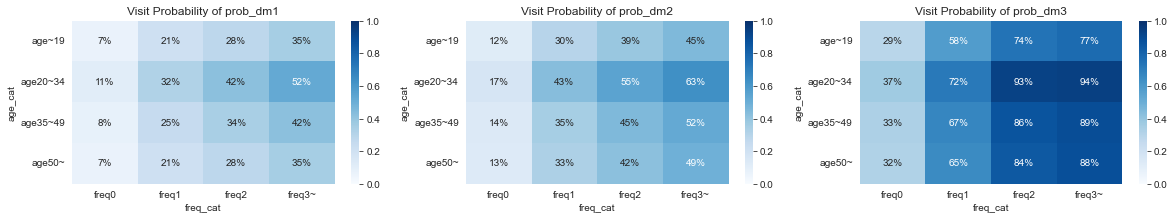

In [10]:
import matplotlib.pyplot as plt
from IPython.display import display

ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['prob_dm1', 'prob_dm2', 'prob_dm3']):
    prob_pivot_df = pd.pivot_table(data=prob_df, values=ptn, columns='freq_cat', index='age_cat')
    prob_pivot_df = prob_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(prob_pivot_df, vmin=0, vmax=1, annot=True, fmt='.0%', cmap='Blues', ax=ax[i])
    ax[i].set_title(f"Visit Probability of {ptn}")

plt.show()

Data の傾向
- 同じ Segment では、Coupon の金額が大きい Pattern の順に来店率が高くなる。
- 同じ年齢区分では、昨年度来店数が多いほど来店率が高くなる。
- 同じ昨年度来店回数区分では、20~34歳の来店率が高く、19歳以下は少ない。

## 数理 Modeling と実装

### 会員個別送付 Model
- 会員ひとりひとりに対してどの Pattern の Direct mail（以下、DM） を送付するか勝手位する問題。
- 各 Pattern の Direct mail をそれぞれの会員に送付するかどうか {0, 1} の二択の **離散変数** を考える。

In [11]:
import pulp

problem = pulp.LpProblem(name='DiscountCouponProblem1', sense=pulp.LpMaximize)
# Campaign の目的が割引 Coupon 付与による来客増加数を最大化することなので、sense=pulp.LpMaximize

### 要件(1). 各会員に対してどの Pattern の DM を送付するか決定
- 会員の List: *I*
- Direct mail の Pattern の List: *M*(={1, 2, 3})
    - 1: Sale のチラシのみ
    - 2: Sale のチラシと、1,000円 Coupon
    - 3: Sale のチラシと、2,000円 Coupon
- 決定変数: *x_im ∊{0, 1} (i∊I, m∊M)*
    会員 *i(∊I)* に対して Direct mail の Pattern *m(∊M)* を送付するばあに 1, しない場合に 0 をとる変数

In [12]:
# 会員 ID の List
I = cust_df['customer_id'].tolist()

In [13]:
# Direct mail の Pattern
M = {1, 2, 3}

In [14]:
# (1) 各会員に対してどの Pattern の Direct mail を送付するか決定
x_im = {}
for i in I:
    for m in M:
        x_im[i, m] = pulp.LpVariable(name=f"x_im{i},{m}", cat='Binary')
        # 決定変数は 0 か 1 をとる二値変数のため、cat='Binary'

# 決定変数の数
len(x_im)

15000

決定変数の数は、5,000顧客 × 3 Pattern で 15,000変数となっている。

### 要件(2). 各会員に対して送付する DM はいずれか 1 Pattern
-   \sum_m∊M(x_im = 1) (i∊I)

In [15]:
# (2). 各会員に対して送付する Direct mail はいずれか 1 Pattern
for i in I:
    problem += pulp.lpSum(x_im[i, m] for m in M) == 1

### 要件(3). Coupon 付与による来客増加数を最大化
- 定数: P_im∊\[0, 1] (i∊I, m∊M)
- 要件(3) Coupon 付与による来客増加数を最大化: \sum_i∊I\sum_m∊M((P_im - P_i1))x_im

In [16]:
# 各会員にそれぞれの Pattern の Direct mail を送付したときの来店率を得る。
# (会員 Data と 来店率 Data を年齢区分と昨年度来店回数区分の列 Key として結合すると、各会員にそれぞれの Pattern の Direct mail を送付した時の来店率が求められる。)
keys = ['age_cat', 'freq_cat']
cust_prob_df = pd.merge(cust_df, prob_df, on=keys)
cust_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [17]:
# 会員に対して各 Pattern の Direct mail を送付したときの来店率が横に並んだ横持ちの状態の DataFrame を、１つの行に１つの Pattern の来店率のみを格納した縦持ちの形式に変換する。
cust_prob_ver_dr = cust_prob_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3}).melt(
    id_vars=['customer_id'],
    value_vars=[1, 2, 3], var_name='dm',
    value_name='prob')

display(cust_prob_ver_dr)

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42
...,...,...,...
14995,4474,3,0.74
14996,4596,3,0.74
14997,4720,3,0.74
14998,4910,3,0.74


In [18]:
# 縦持ち Data から定数 P_im をの辞書を作成
P_im = cust_prob_ver_dr.set_index(['customer_id', 'dm'])['prob'].to_dict()

In [19]:
# P_im に (会員ID, DMの送付Pattern) の Tuple を key に渡すことで来店率を Value として取得できる。
P_im[(1, 1)]  # 会員ID が 1 の会員に Pattern 1 の DM を送付したときの来店率

0.42

In [20]:
# 目的関数(要件(3). Coupon 付与による来客増加数を最大化)を実装
problem += pulp.lpSum((P_im[i, m] - P_im[i, 1]) * x_im[i, m] for i in I for m in [2, 3])
# Coupon を付与しない場合には目的関数に影響を与えないため、DMの送付 Pattern 2, 3 のみ処理

### 要件(4). 会員の予算消費期待値の合計は 100万以下
- 定数: C_m∊{0, 1000, 2000} (m∊M)
    DM の Pattern m(∊M) に付与する Coupon の金額
- ∑_i∊-∑_m∊M-C_m-P_im-x_im ≦　1,000,000

In [21]:
# DM の Pattern を Key として Coupon の金額を返す dict(C_m) を定義する。
C_m = {1: 0, 2: 1000, 3: 2000}

In [22]:
# 要件(4). 顧客の消費する費用の期待値の合計は 1,000,000円以下
problem += pulp.lpSum(C_m[m] * P_im[i, m] * x_im[i, m] for i in I for m in [2, 3]) <= 1_000_000

### 要件(5). 各 Pattern の DM をそれぞれの Segment に属する 10% 以上に送付
- 定数: N_s∊非負整数N　(s∊S)
    Segment に属する会員数
- 定数: Z_is∊{0, 1} (i∊I, s∊S)
    会員 i(∊I) が Segment s(∊S) に属する場合 1, そうでない場合に 0 となる定数
- 要件(5) 各 Pattern の DM それぞれの Segment に属する会員 10% 以上に送付

In [23]:
# Segment の List
S = prob_df['segment_id'].tolist()
len(S)

16

In [24]:
# 各 Segment とその Segment に属する顧客数を対応させる Dict の作成
N_s = cust_prob_df.groupby('segment_id')['customer_id'].count().to_dict()
print(N_s)

{1: 200, 2: 150, 3: 50, 4: 100, 5: 600, 6: 450, 7: 150, 8: 300, 9: 800, 10: 600, 11: 200, 12: 400, 13: 400, 14: 300, 15: 100, 16: 200}


In [25]:
# 会員を Key として属する Segment を返す辞書
S_i = cust_prob_df.set_index('customer_id')['segment_id'].to_dict()

In [26]:
# (5) 各 Pattern の DM をそれぞれの Segment に属する会員数の 10% 以上送付
for s in S:
    for m in M:
        problem += pulp.lpSum(x_im[i, m] for i in I if S_i[i] == s) >= 0.1 * N_s[s]

In [27]:
# 計算時間を計算して求解
import time

time_start = time.time()
status = problem.solve()
time_stop = time.time()

print(f"Status: {pulp.LpStatus[status]}")
print(f"目的関数値: {pulp.value(problem.objective):.4}")
print(f"計算時間: {time_stop - time_start:.3}(秒)")

Status: Optimal
目的関数値: 326.1
計算時間: 8.37(秒)


- 目的関数値（来客増加数）が「326.1」であることから 100万円投資して Campaign を行なうことで、全会員へ Coupon を付与しない DM を送付するよりも約326人多くの来客者を獲得できると解釈できる。
<br>

- CPA(cost per action: 今回の Campaign での投資効果を来店数 1人あたりの獲得費用)で換算すると、100万円 / 326人 より約 3,067円で 1会員の来客を増やすことができると評価できる。

### 実際に得られた解を確認して、どの Segment に対して Coupon が付与されているか確認

In [28]:
# 会員 i に対してどの Pattern の DM を送付するかの解 x_im[i, m].value() を加工して DataFrame にする
send_dm_df = pd.DataFrame([[x_im[i, m].value() for m in M] for i in I], columns=['send_dm1', 'send_dm2', 'send_dm3'])
send_dm_df.head()

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [29]:
# 送付 Pattern の Columns で、それぞれの会員に対して各 Pattern の DM を送付するかしないかわかるようにする
cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
cust_send_df.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,0.0,1.0
4,5,age35~49,freq0,0.0,1.0,0.0


### 各 Segment に対するそれぞれの DM の送付率と送付数を可視化

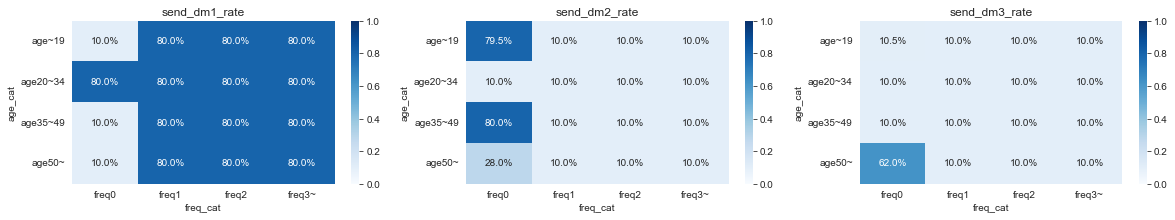

In [30]:
# 各 Segment に対するそれぞれの DM の送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat',
                                        aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f"{ptn}_rate")
plt.show()

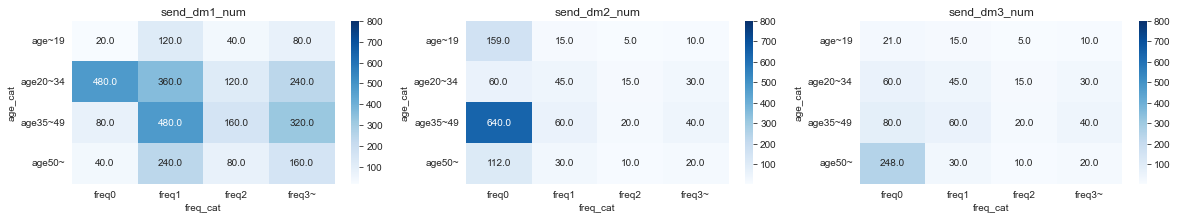

In [31]:
# 各 Segment に対するそれぞれの DM の送付数
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat',
                                        aggfunc='sum')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1f', cmap='Blues', vmax=800, ax=ax[i])
    ax[i].set_title(f'{ptn}_num')
plt.show()

- 要件(5). の条件どおり、すべての Segment に対して各 Pattern の DM が 10%以上送付されている。
- freq0 の Segment では 2,000円の Coupon が 62% と多い。
- 年齢区分は age~19, age35~49 で昨年来店回数区分は freq0 の Segment会員では、1,000円 Coupon が約 80%と多く送付されている。

### Segment 送付 Model
- 会員の Segment に対して各 Pattern の DM をどの程度送付するかを決定する問題。
- 各 Pattern の DM を各 Segment にどの程度の割合で送付するか、という\[0, 1](0 から 1 の連続変数)を決定する。

In [32]:
# 数理 Model の Instance を作成
problem = pulp.LpProblem(name='DiscountCouponProblem2', sense=pulp.LpMaximize)

### 要件(1). 各会員に対してどの Pattern の DM を送付するかを決定
同じ Segment に属する会員の来店率の見積もりは変わらないことを利用して、
- 各会員に対してどの Pattern の DM を送付するか
- 各 Segment に対してそれぞれの Pattern の DM をどの程度送付するか

という視点で捉える。

決定変数: *x_sm∊\[0, 1](s∊S, m∊M)*
- Segment *s(∊S)* に対する DM の Pattern *m(∊M)* の送付率。

In [33]:
x_sm = {}
# [0, 1] の変数を宣言
for s in S:
    for m in M:
        x_sm[s, m] = pulp.LpVariable(name=f'x_sm({s},{m})', lowBound=0, upBound=1, cat='Continuous')
len(x_sm)

48

Segment数 16 と DM の Pattern数 3 の積で 48変数となった。

### 要件(2). 各会員に対して送付する DM はいずれか 1 Pattern

*∑_m∊M(x_sm) = 1 (s∊S)*

各 Segment に送付する DM の Pattern の送付率の和が 100% であることになる。

In [34]:
for s in S:
    problem += pulp.lpSum(x_sm[s, m] for m in M) == 1

### 要件(3). Coupon 付与による来客増加数を最大化
定数: *P_sm∊\[0,1] (s∊S, m∊M)*
- Segment s(∊S) の会員に対して DM Pattern m(∊M) で送付したときの来店率

要件(3). Coupon 付与による来客増加数を最大化
∑_s∊S･∑_m∊M･N_s(P_sm - P_s1)･x_sm

In [35]:
# 定数 P_sm の定義
prob_ver_df = prob_df.rename(columns={'prob_dm1': 1, 'prob_dm2': 2, 'prob_dm3': 3}).melt(id_vars=['segment_id'],
                                                                                         value_vars=[1, 2, 3],
                                                                                         var_name='dm',
                                                                                         value_name='prob')
P_sm = prob_ver_df.set_index(['segment_id', 'dm'])['prob'].to_dict()

In [36]:
# 目的関数の実装
problem += pulp.lpSum(N_s[s] * (P_sm[s, m] - P_sm[s, 1]) * x_sm[s, m] for s in S for m in [2, 3])

### 要件(4) 会員の予算消費期待値の合計は 100万円以下
*∑_s∊S･∑_m∊M･C_m･N_s･P_sm･x_sm <= 1,000,000*

In [37]:
problem += pulp.lpSum(C_m[m] * N_s[s] * P_sm[s, m] * x_sm[s, m] for s in S for m in [2, 3]) <= 1_000_000

### 要件(5). 各 Pattern の DM がそれぞれの Segment に属する会員数の 10 % 以上送付
*x_sm ≧ 0.1 (s∊S, m∊M)*

In [38]:
for s in S:
    for m in M:
        problem += x_sm[s, m] >= 0.1

In [39]:
# 求解
time_start = time.time()
status = problem.solve()
time_stop = time.time()

print(f"Status: {pulp.LpStatus[status]}")
print(f"目的関数: {pulp.value(problem.objective):.4}")
print(f"計算時間: {(time_stop - time_start):.3}(秒)")

Status: Optimal
目的関数: 326.1
計算時間: 0.029(秒)


In [32]:
# 会員 i に対してどの Pattern の DM を送付するかの解 x_im[i, m].value() を加工して DataFrame にする
send_dm_df = pd.DataFrame([[x_im[i, m].value() for m in M] for i in I], columns=['send_dm1', 'send_dm2', 'send_dm3'])
send_dm_df.head()

,send_dm1,send_dm2,send_dm3
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0


In [35]:
# 送付 Pattern の Columns で、それぞれの会員に対して各 Pattern の DM を送付するかしないかわかるようにする
cust_send_df = pd.concat([cust_df[['customer_id', 'age_cat', 'freq_cat']], send_dm_df], axis=1)
cust_send_df.head()

,customer_id,age_cat,freq_cat,send_dm1,send_dm2,send_dm3
0,1,age20~34,freq2,0.0,1.0,0.0
1,2,age35~49,freq0,0.0,1.0,0.0
2,3,age35~49,freq0,0.0,1.0,0.0
3,4,age~19,freq0,0.0,0.0,1.0
4,5,age35~49,freq0,0.0,1.0,0.0


### 各 Segment に対するそれぞれの DM の送付率と送付数を可視化

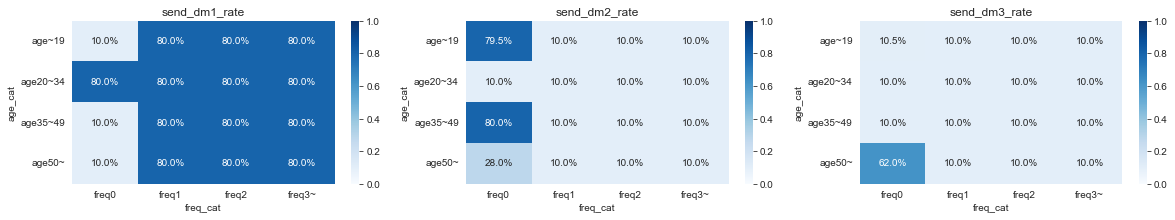

In [37]:
# 各 Segment に対するそれぞれの DM の送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize=(20, 3))
for i, ptn in enumerate(['send_dm1', 'send_dm2', 'send_dm3']):
    cust_send_pivot_df = pd.pivot_table(data=cust_send_df, values=ptn, columns='freq_cat', index='age_cat',
                                        aggfunc='mean')
    cust_send_pivot_df = cust_send_pivot_df.reindex(['age~19', 'age20~34', 'age35~49', 'age50~'])
    sns.heatmap(cust_send_pivot_df, annot=True, fmt='.1%', cmap='Blues', vmin=0, vmax=1, ax=ax[i])
    ax[i].set_title(f"{ptn}_rate")
plt.show()

In [ ]:
# TODO: 各 Segment に対するそれぞれの DM の送付数